In [ ]:
from pandas import DataFrame
from data201 import db_connection, df_query

In [ ]:
conn_warehouse = db_connection(config_file = 'zagi-warehouse.ini')
cursor_warehouse = conn_warehouse.cursor()

In [ ]:
def make_table(table, sql):
    cursor_warehouse.execute(f"DROP TABLE IF EXISTS {table}")
    cursor_warehouse.execute(sql)

In [ ]:
def display_table(table, order_by=''):
    sql = f"SELECT * FROM {table}"
    
    if order_by != '':
        sql = sql + " ORDER BY " + order_by
        
    return df_query(conn_warehouse, sql) 

## Aggregated Sales fact table per Day, Product, Customer, Store (DPCS)
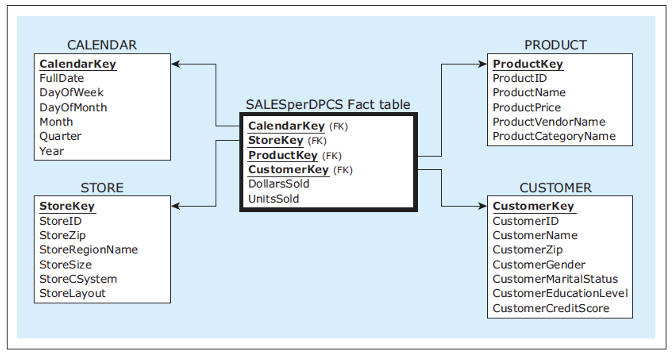

In [ ]:
sql = ( 
    """
    CREATE TABLE sales_per_dpcs
    (
        calendar_key INT,
        store_key    INT,
        product_key  INT,
        customer_key INT,
        dollars_sold DOUBLE,
        units_sold   INT,
        line_count   INT,
        PRIMARY KEY(calendar_key, store_key, product_key, customer_key),
        FOREIGN KEY (calendar_key) REFERENCES calendar(calendar_key),
        FOREIGN KEY (store_key)    REFERENCES store(store_key),
        FOREIGN KEY (product_key)  REFERENCES product(product_key),
        FOREIGN KEY (customer_key) REFERENCES customer(customer_key)
    )
    """
)

make_table('sales_per_dpcs', sql)

#### Total amount sold in dollars and units 
- #### on a particular day
- #### for a particular product
- #### for a particular customer
- #### for a particular store.

In [ ]:
sql = ( 
    """
    INSERT INTO sales_per_dpcs(calendar_key, store_key, 
                               product_key, customer_key,
                               dollars_sold, units_sold,
                               line_count)
        SELECT calendar_key, store_key, product_key, customer_key,
               SUM(dollars_sold), SUM(units_sold), COUNT(tid)
        FROM sales
        GROUP BY calendar_key, store_key, product_key, customer_key
    """
)

cursor_warehouse.execute(sql)
conn_warehouse.commit()

display_table('sales_per_dpcs', 
              'calendar_key, store_key, product_key, customer_key')

## Aggregated Sales fact table per Day, Customer, Store (DCS)
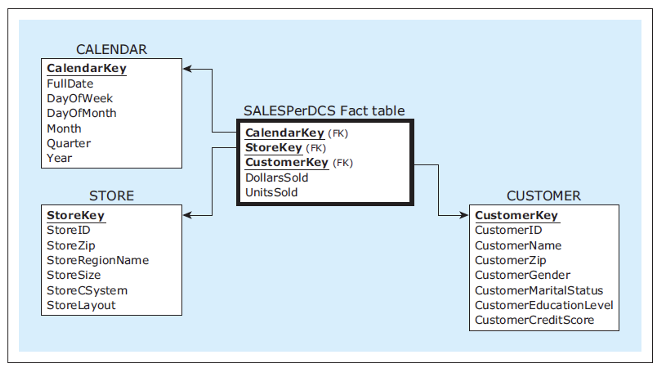

In [ ]:
sql = ( 
    """
    CREATE TABLE sales_per_dcs
    (
        calendar_key INT,
        store_key    INT,
        customer_key INT,
        dollars_sold DOUBLE,
        units_sold   INT,
        line_count   INT,
        PRIMARY KEY(calendar_key, store_key, customer_key),
        FOREIGN KEY (calendar_key) REFERENCES calendar(calendar_key),
        FOREIGN KEY (store_key)    REFERENCES store(store_key),
        FOREIGN KEY (customer_key) REFERENCES customer(customer_key)
    )
    """
)

make_table('sales_per_dcs', sql)

#### Total amount sold in dollars and units 
- ### on a particular day
- ### for a particular customer
- ### for a particular store
#### for all products.

In [ ]:
sql = ( 
    """
    INSERT INTO sales_per_dcs(calendar_key, store_key, customer_key,
                              dollars_sold, units_sold, line_count)
        SELECT calendar_key, store_key, customer_key,
               SUM(dollars_sold), SUM(units_sold), COUNT(tid)
        FROM sales
        GROUP BY calendar_key, store_key, customer_key
    """
)

cursor_warehouse.execute(sql)
conn_warehouse.commit()

display_table('sales_per_dcs', 
              'calendar_key, store_key, customer_key')

In [ ]:
cursor_warehouse.close()
conn_warehouse.close()